<a href="https://colab.research.google.com/github/jarinari/Algorithmic-Trading-Plugins/blob/master/ripper_vs_dt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Vamos a comparar los resultados de las reglas extraídas con árboles de decisión contra las reglas extraídas con un algoritmo llamado Ripper.

Para ello obtendremos 1000 reglas con cada modelo entrenando en un periodo de 10 años y compararemos los resultados en un forward de 6 meses.

#ENTORNO

In [ ]:
#INSTALACIÓN DE LIBRERÍAS
!pip install pandas_ta
!pip install wittgenstein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=f6e7e127ab5682e9faa707c7ca7eaf8795b8eeb9b94265c33763c7176de7418f
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.6/110.6 kB 1.8 MB/s eta 0:00:00


In [ ]:
#IMPORTACIÓN DE LIBRERÍAS
import gdown
import pandas as pd
import pandas_ta as ta
import numpy as np
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import _tree, DecisionTreeClassifier
import wittgenstein as lw
import warnings
warnings.filterwarnings('ignore')

#FUNCIONES

In [ ]:
#FUNCIÓN PARA DESCARGAR HISTÓRICOS ALMACENADOS EN DRIVE
def get_data(ticker):
  if ticker=='EURUSD':
    url = 'https://drive.google.com/uc?id=1LlY2GBrcT_-sJqthhj6uC-IwSEY9a8WT'

  output = "archivo.csv"
  gdown.download(url, output, quiet=True)
  data = pd.read_csv(output)

  data.columns = ["Date", "Time", "Open", "High", "Low", "Close", "Volume"]
  data = data.set_index("Date")
  data = data.drop(["Time", "Volume"], axis=1)

  return data

In [ ]:
#FUNCIÓN PARA CALCULAR RETORNOS A UN DÍA VISTA OPERANDO EN LA APERTURA
def get_returns(data):
  data['Return'] = (data['Open'].shift(-2) - data['Open'].shift(-1))
  return data

In [ ]:
#FUNCIÓN PARA TRANSFORMAR LOS RETORNOS EN PIPS
def get_returns_pips(ticker):
  if 'JPY' in ticker:
    mult = 100
  else:
    mult = 10000
  return mult

In [ ]:
#FUNCIÓN PARA CALCULAR FEATURES SELECCIONADAS
def get_indicators(data):

  #Extraer columnas necesarias para el cálculo de indicadores
  close = data["Close"]
  high = data["High"]
  low = data["Low"]

  #Crear de listas para guardar el nombre de los indicadores y los valores
  indicators = []
  columns = []

  #CCI - Commodity Channel Index
  for n in np.arange(2,100):
    name = "CCI" + str(n)
    indicators.append(ta.cci(high, low, close, n))
    columns.append(name)
  #NORMALIZED AVERANGE TRUE RANGE
  for n in np.arange(2,100):
    name = "NATR" + str(n)
    indicators.append(ta.natr(high, low, close, n))
    columns.append(name)
  #RSI - Relative Strength Index
  for n in np.arange(2,100):
    name = "RSI" + str(n)
    indicators.append(ta.rsi(close, n))
    columns.append(name)
  #WILLR - Williams' %R
  for n in np.arange(2,100):
    name = "WILLR" + str(n)
    indicators.append(ta.willr(high, low, close, n))
    columns.append(name)
  #ADX
  for n in np.arange(2,100):
    adx = ta.adx(high, low, close, n)
    name = "ADX" + str(n)
    indicators.append(adx["ADX_"+str(n)])
    columns.append(name)
  #DMP
  for n in np.arange(2,100):
    adx = ta.adx(high, low, close, n)
    name = "DMP" + str(n)
    indicators.append(adx["DMP_"+str(n)])
    columns.append(name)
  #DMN
  for n in np.arange(2,100):
    adx = ta.adx(high, low, close, n)
    name = "DMN" + str(n)
    indicators.append(adx["DMN_"+str(n)])
    columns.append(name)
  #MOMENTUM
  for n in np.arange(2,100):
    name = "MOM" + str(n)
    indicators.append(ta.mom(close, n))
    columns.append(name)

  #Crear dataframe con todos los indicadores calculados
  df = pd.concat(indicators, axis=1)
  df.columns = columns
  df.index = data.index
  df["Open"] = data["Open"]
  df['High'] = data['High']
  df['Low'] = data['Low']
  df['Close'] = data['Close']

  #Eliminar las filas con valores faltantes
  df = df.dropna()

  return df

In [ ]:
#FUNCIÓN PARA OBTENER EL DATASET
def get_dataset(ticker):
  #Obtener el histórico
  data = get_data(ticker)
  #Acotar el histórico
  data = data.loc['2011.01.01':'2022.07.01', :]
  #Calcular indicadores
  data = get_indicators(data)
  #Calcular retorno en pips a 1 día vista
  data = get_returns(data)
  data['Return'] = data['Return'] * get_returns_pips(ticker)
  #Obtener etiquetado
  data['Label'] = np.where(data['Return'] > 10, 1, 0)
  #Limpiar dataset
  data = data.drop(['High', 'Low'], axis=1)
  data = data.loc['2012.01.01':'2022.07.01', :]
  data = data.dropna()

  return data

In [ ]:
#FUNCIÓN PARA OBTENER REGLAS A PARTIR DE UN ÁRBOL DE DECISIÓN
def _tree_to_rules(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature]
    rules = []

    def recurse(node, base_name):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            symbol = '<='
            symbol2 = '>'
            threshold = tree_.threshold[node]
            text = base_name + ["{} {} {}".format(name, symbol, threshold)]
            recurse(tree_.children_left[node], text)

            text = base_name + ["{} {} {}".format(name, symbol2,
                                                  threshold)]
            recurse(tree_.children_right[node], text)
        else:
            rule = '(' + str.join(') & (', base_name) + ')'
            rule = (rule if rule != ''
                    else ' == '.join([feature_names[0]] * 2))
            rules.append(rule)

    recurse(0, [])

    return rules if len(rules) > 0 else 'True'

#DATOS

In [ ]:
#DATASET
data = get_dataset('EURUSD')

#PARTICIÓN
train = data.loc['2012.01.01':'2022.01.01', :]
forward = data.loc['2022.01.01':'2022.07.01', :]

#FEATURES
X = train.iloc[:,:-4]

#LABEL
Y = train['Label']

#DECISION TREE

In [ ]:
#REGLAS OBTENIDAS CON DECISION TREE
#Crear listas en la que almacenar las reglas
rules_list = []
sqn_train = []
sqn_forward = []
#Crear bucle para la obtención de las 1000 reglas a base de árboles de decisión
while len(rules_list)<1000:
  clf = DecisionTreeClassifier(criterion='entropy',
                                splitter='random',
                                max_depth=3,
                                min_samples_split=100,
                                min_samples_leaf=50,
                                max_features='sqrt')
  clf.fit(X, Y)
  #Traducir los árboles de decisión en reglas
  rules = _tree_to_rules(tree=clf, feature_names=X.columns)
  #Guardar las reglas
  for rule in rules:
    #Comprobar que la regla predice la etiqueta 1
    if train.query(rule)['Return'].mean() > 0:
      #Almacenar regla y resultados
      rules_list.append(rule)
      train_trades = train.query(rule)['Return']
      sqn_train.append((train_trades.mean()/train_trades.std())*len(train_trades)**0.5)
      forward_trades = forward.query(rule)['Return']
      sqn_forward.append((forward_trades.mean()/forward_trades.std())*len(forward_trades)**0.5)

#Crear dataframe con los resultados
df_dt = pd.DataFrame({'Rule': rules_list, 'SQN_TRAIN': sqn_train, 'SQN_FORWARD': sqn_forward})
df_dt = df_dt.fillna(0)

df_dt

,Rule,SQN_TRAIN,SQN_FORWARD
0,(ADX53 <= 14.698837205859272) & (NATR93 > 0.76...,2.033637,0.000000
1,(ADX53 > 14.698837205859272) & (ADX66 <= 15.00...,0.060766,-2.200878
2,(ADX53 > 14.698837205859272) & (ADX66 > 15.009...,0.578979,0.475050
3,(NATR85 <= 0.4368021623919018) & (NATR54 > 0.3...,0.013519,0.000000
4,(NATR85 > 0.4368021623919018) & (WILLR90 <= -3...,0.357538,-1.240031
...,...,...,...
996,(NATR35 > 0.5901917324928989) & (RSI11 <= 51.9...,0.927228,-0.866527
997,(NATR35 > 0.5901917324928989) & (RSI11 <= 51.9...,0.501738,0.841962
998,(NATR35 > 0.5901917324928989) & (RSI11 > 51.95...,0.503723,0.000000
999,(NATR98 > 0.4884535996202513) & (RSI14 <= 48.0...,0.880679,0.000000


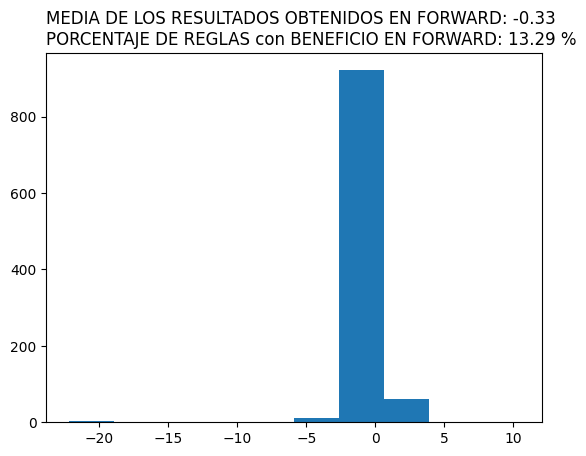

In [ ]:
#PORCENTAJE DE REGLAS GANADORAS EN FORWARD
count = 0
for sqn in df_dt['SQN_FORWARD']:
  if sqn > 0:
    count +=1
perc = count*100/len(df_dt['SQN_FORWARD'])

#DISTRIBUCIÓN DE RESULTADOS EN FORWARD
plt.hist(df_dt['SQN_FORWARD'], bins=10)
media = 'MEDIA DE LOS RESULTADOS OBTENIDOS EN FORWARD: ' + str(round(df_dt['SQN_FORWARD'].mean(),2))
porcentaje = '\nPORCENTAJE DE REGLAS con BENEFICIO EN FORWARD: ' + str(round(perc,2)) + ' %'
title = media + porcentaje
plt.title(title, loc='left')
plt.show()

#RIPPER

In [ ]:
#REGLAS OBTENIDAS CON RIPPER Y CÁLCULO DEL SQN EN TRAIN Y FORWARD
#Crear listas en la que almacenar las reglas
rules_list = []
sqn_train_list = []
sqn_forward_list = []
#Crear bucle para la obtención de las 1000 reglas a base de árboles de decisión
while len(rules_list) < 1000:
  #Obtener reglas con ripper
  ripper_clf = lw.RIPPER(max_rules=1)
  ripper_clf.fit(X.sample(10, axis=1), Y)
  rule = str(ripper_clf.ruleset_[0])
  #Calcular y almacenar resultados
  train_bt = train.copy()
  train_bt['pred'] = ripper_clf.predict(train_bt)
  train_trades = train_bt[train_bt['pred']==True]['Return']
  rules_list.append(rule)
  sqn_train = (train_trades.mean()/train_trades.std())*len(train_trades)**0.5
  sqn_train_list.append(sqn_train)
  forward_bt = forward.copy()
  forward_bt['pred'] = ripper_clf.predict(forward_bt)
  forward_trades = forward_bt[forward_bt['pred']==True]['Return']
  sqn_forward = (forward_trades.mean()/forward_trades.std())*len(forward_trades)**0.5
  sqn_forward_list.append(sqn_forward)

#Crear dataframe con los resultados
df_ripper = pd.DataFrame({'Rule': rules_list, 'SQN_TRAIN': sqn_train_list, 'SQN_FORWARD': sqn_forward_list})
df_ripper = df_ripper.fillna(0)

df_ripper

,Rule,SQN_TRAIN,SQN_FORWARD
0,[MOM49=0.026-0.043^RSI35=49.37-51.31],2.193861,0.000000
1,[WILLR90=-92.81--83.65^RSI99=43.42-45.85^WILLR...,1.420062,-2.216721
2,[MOM46=-0.046--0.028^NATR48=0.71-0.78],1.054208,-0.938969
3,[ADX39=>24.19^MOM30=<-0.033],-0.052274,0.000000
4,[CCI96=-155.5--114.01^MOM18=<-0.027],1.467491,-0.606128
...,...,...,...
995,[DMP98=24.46-25.29^RSI40=49.34-51.11],1.769081,0.000000
996,[WILLR83=-92.88--83.94^DMN29=22.8-24.42],2.217304,0.000000
997,[ADX68=14.29-16.03^ADX90=11.3-12.79^NATR84=0.6...,2.162857,0.000000
998,[RSI19=40.05-43.72^CCI86=-47.28--10.24^CCI56=-...,4.302404,0.000000


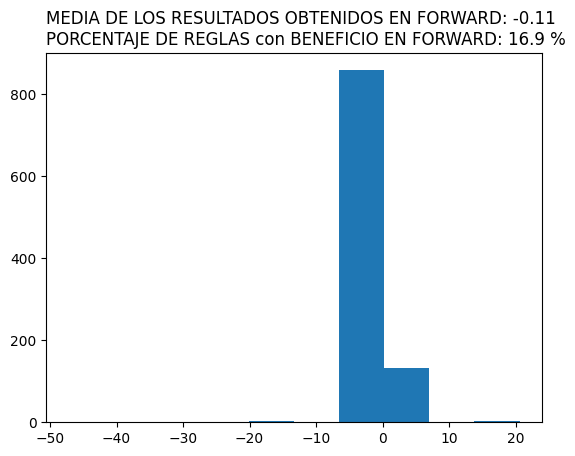

In [ ]:
#PORCENTAJE DE REGLAS GANADORAS EN FORWARD
count = 0
for sqn in df_ripper['SQN_FORWARD']:
  if sqn > 0:
    count +=1
perc = count*100/len(df_ripper['SQN_FORWARD'])

#DISTRIBUCIÓN DE RESULTADOS EN FORWARD
plt.hist(df_ripper['SQN_FORWARD'], bins=10)
media = 'MEDIA DE LOS RESULTADOS OBTENIDOS EN FORWARD: ' + str(round(df_ripper['SQN_FORWARD'].mean(),2))
porcentaje = '\nPORCENTAJE DE REGLAS con BENEFICIO EN FORWARD: ' + str(round(perc,2)) + ' %'
title = media + porcentaje
plt.title(title, loc='left')
plt.show()

#CONCLUSIONES

Con las reglas en bruto (sin feature selection, sin filtrar las reglas...), Ripper obtiene un resultado medio en forward superior a Decision Tree y un mayor porcentaje de reglas obtienen beneficios en forward.

Sin embargo, la inmensa mayoría de reglas siguen siendo pura sobreoptimización.